In [11]:
import pandas as pd

path = '/Users/brunobarbieri/Library/CloudStorage/OneDrive-UniversityofPisa/TA_Project/data/'
df = pd.read_csv(path + "lab_lem_merge.csv")

In [12]:
import ast

df['lemmatized_stanzas'] = df['lemmatized_stanzas'].apply(ast.literal_eval)
df

,id,title,artist,year,views,features,is_country,is_pop,is_rap,is_rb,is_rock,stanza_number,is_chorus,lemmatized_stanzas,label
0,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,0,False,"[she, get, a, broke, down, el, camino, in, the...",anger
1,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,1,True,"[something, in, the, water, something, in, the...",anger
2,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,2,False,"[she, do, her, makeup, and, hair, to, cook, fr...",anticipation
3,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,4,False,"[my, hoosi, girl, be, so, fine, shake, the, wa...",fear
4,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,5,True,"[something, in, the, water, something, in, the...",fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108255,22140,Infomercial Interlude,KJ-52,2003,67,{''},False,True,False,False,False,0,False,"[kj-52, tired, of, those, cd, 's, that, do, no...",surprise
108256,22140,Infomercial Interlude,KJ-52,2003,67,{''},False,True,False,False,False,1,False,"[todd, collin, in, weird, voice, that, be, rig...",anticipation
108257,22140,Infomercial Interlude,KJ-52,2003,67,{''},False,True,False,False,False,2,False,"[kj-52, but, do, not, take, our, word, for, it...",sadness
108258,22140,Infomercial Interlude,KJ-52,2003,67,{''},False,True,False,False,False,3,False,"[I, use, to, be, a, cross, eye, bowlegge, one,...",joy


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np


# Step 1: Convert token lists back into space-separated strings
# (needed for vectorizer)
# texts_str = df['lemmatized_stanzas'].apply(
#     lambda tokens: " ".join(tokens)
# )
# print(texts_str)
df['text_str'] = df['lemmatized_stanzas'].apply(lambda x: ' '.join(x))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[[
        'text_str', 'title', 'stanza_number', 'is_country',
        'is_pop', 'is_rap', 'is_rb', 'is_rock', 'is_chorus'
    ]],
    df['label'], test_size=0.3, random_state=42
)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer

def convert_bool_to_int(x):
    return x.astype(int)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'text_str'),
        ('title_topic', TfidfVectorizer(), 'title'),
        ('scaler', StandardScaler(), ['stanza_number']),
        (
            'bools', FunctionTransformer(
                convert_bool_to_int, validate=False
            ), [
                'is_country', 'is_pop', 'is_rap',
                'is_rb', 'is_rock', 'is_chorus'
            ]
        )

])


# Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Define the pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_distributions = {
    'preprocessor__text__max_features': [500, 1000, 5000, None],  # Max features for TF-IDF
    'preprocessor__text__ngram_range': [(1, 1), (1, 2)],          # Unigrams or bigrams
    'classifier__n_estimators': [50, 100, 200, 300],              # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],                  # Tree depth
    'classifier__min_samples_split': [2, 5, 10],                  # Min samples per split
    'classifier__min_samples_leaf': [1, 2, 4],                    # Min samples per leaf
    'classifier__bootstrap': [True, False],                       # Bootstrap sampling
}

# RandomizedSearchCV setup
random_search_rf = RandomizedSearchCV(
    estimator= rf_pipeline,
    param_distributions= rf_param_distributions,
    n_iter=20,                                  # Number of random combinations to try
    cv=5,                                       # 5-fold cross-validation
    scoring='accuracy',                         # Metric to optimize
    verbose=2,
    random_state=42,
    n_jobs=-1                                   # Use all available cores
)

In [7]:
# Fit RandomizedSearchCV to the data
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300, preprocessor__text__max_features=5000, preprocessor__text__ngram_range=(1, 1); total time=  40.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300, preprocessor__text__max_features=5000, preprocessor__text__ngram_range=(1, 1); total time=  40.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300, preprocessor__text__max_features=5000, preprocessor__text__ngram_range=(1, 1); total time=  40.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300, preproce

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('text',
                                                                               TfidfVectorizer(),
                                                                               'text_str'),
                                                                              ('title_topic',
                                                                               TfidfVectorizer(),
                                                                               'title'),
                                                                              ('scaler',
                                                                               StandardScaler(),
                                                                               ['stanza_number']),
                                                                              ('bools',
                                                                               FunctionTransformer(func=<function convert_bool_to_int at 0x14358d1c0>),
                                                                               ['is_country',
                                                                                'is_pop',
                                                                                'is_rap',
                                                                                'is_rb',
                                                                                'is_rock...
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [50, 100,
                                                                     200, 300],
                                        'preprocessor__text__max_features': [500,
                                                                             1000,
                                                                             5000,
                                                                             None],
                                        'preprocessor__text__ngram_range': [(1,
                                                                             1),
                                                                            (1,
                                                                             2)]},
                   random_state=42, scoring='accuracy', verbose=2)

In [8]:
# Best parameters and cross-validation accuracy
print(f"Best Parameters: {random_search_rf.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search_rf.best_score_}")

# Predict on the test set
y_pred = random_search_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

Best Parameters: {'preprocessor__text__ngram_range': (1, 2), 'preprocessor__text__max_features': None, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__bootstrap': False}
Best Cross-Validation Accuracy: 0.3366498616495286
              precision    recall  f1-score   support

       anger       0.45      0.58      0.51      4436
anticipation       0.42      0.18      0.25      3715
     disgust       0.43      0.11      0.18      3178
        fear       0.35      0.27      0.31      4652
         joy       0.27      0.77      0.40      5854
     sadness       0.53      0.16      0.25      3503
    surprise       0.38      0.18      0.24      3623
       trust       0.48      0.16      0.24      3517

    accuracy                           0.34     32478
   macro avg       0.41      0.30      0.30     32478
weighted avg       0.40      0.34      0.31     32478



In [9]:
# saves the model
import joblib
from datetime import datetime

model_path = '/Users/brunobarbieri/Library/CloudStorage/OneDrive-UniversityofPisa/TA_Project/models/'

import joblib
joblib.dump(
    random_search_rf.best_estimator_,
    model_path + 'RF_' + datetime.now().strftime("%d-%m-%Y_%H-%M-%S") + '.pkl'
)

['/Users/brunobarbieri/Library/CloudStorage/OneDrive-UniversityofPisa/TA_Project/models/RF_01-01-2025_16-24-37.pkl']

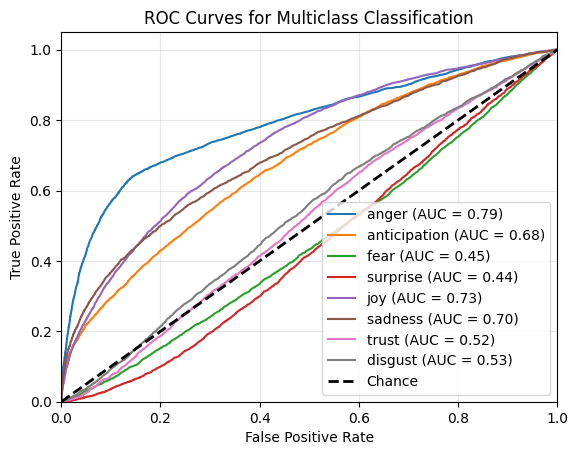

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarizzazione delle etichette per il supporto multi-classe
classes = df['label'].unique()
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Calcolo delle probabilità del modello
# (Nota: LinearSVC non fornisce probabilità, ma possiamo usare la decision_function)
y_score = random_search_rf.best_estimator_.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i, label in enumerate(classes):  # Use unique labels for dynamic legend
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# SVM

In [30]:
from sklearn.svm import SVC
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

# svm_param_distributions = {
#     'preprocessor__text__max_features': [500, 1000, 5000, None],
#     'preprocessor__text__ngram_range': [(1, 1), (1, 2)],
#     'classifier__estimator__C': [0.1, 1, 10, 100],
#     'classifier__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'classifier__estimator__degree': [2, 3, 4],
#     'classifier__estimator__gamma': ['scale', 'auto'],
#     'classifier__estimator__class_weight': [None, 'balanced']
# }

svm_param_distributions = {
    'preprocessor__text__max_features': [500, 1000, 2500],
    'preprocessor__text__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__class_weight': [None, 'balanced']
}



# RandomizedSearchCV setup
random_search_svm = RandomizedSearchCV(
    estimator= svm_pipeline,
    param_distributions= svm_param_distributions,
    n_iter=2,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [2]:
# Fit RandomizedSearchCV to the data
random_search_svm.fit(X_train, y_train)

NameError: name 'random_search_svm' is not defined

In [1]:
# Best parameters and cross-validation accuracy
print(f"Best Parameters: {random_search_svm.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search_svm.best_score_}")

# Predict on the test set
y_pred = random_search_svm.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

NameError: name 'random_search_svm' is not defined

In [ ]:
joblib.dump(
    random_search_rf.best_estimator_,
    model_path + 'SVM_' + datetime.now().strftime("%d-%m-%Y_%H-%M-%S") + '.pkl'
)

['/Users/brunobarbieri/Library/CloudStorage/OneDrive-UniversityofPisa/TA_Project/models/best_svm_pipeline.pkl']

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Ensure the `classes` are sorted consistently for reproducibility
classes = sorted(df['label'].unique())

# Binarize labels for multi-class support
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute the decision function scores from the SVM model
# Ensure the SVM model is trained with the One-vs-Rest (OvR) approach
try:
    y_score = random_search_svm.best_estimator_.decision_function(X_test)
except AttributeError:
    raise ValueError("The selected SVM model does not support decision_function. Ensure it's an SVC with One-vs-Rest.")

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    # Compute the ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Add a reference diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Chance")

# Configure plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class SVM (One-vs-Rest)")
plt.legend(loc="lower right", title="Classes")
plt.grid(alpha=0.3)
plt.show()
